## Objective
The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

Formally, given a training sample of tweets and labels, where label ‘1’ denotes the tweet is racist/sexist and label ‘0’ denotes the tweet is not racist/sexist, your objective is to predict the labels on the given test dataset.

In [1]:
import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import warnings 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt  

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline

## Read data

In [2]:
train  = pd.read_csv('C:\Study\DataSets\AV-Twitter-Sentiment-Analysis\\train_E6oV3lV.csv') 
test = pd.read_csv('C:\Study\DataSets\AV-Twitter-Sentiment-Analysis\\test_tweets_anuFYb8.csv')
train.sample(5)

,id,label,tweet
31910,31911,0,@user @user not a brown-noser?? you're practically making out with hillary in your profile pictureðð¼ð©
7808,7809,0,#hapoyfathersday : #kimkardashian wishes #kanyewest a fathers day ðððððððð . cheekâ¦
14901,14902,0,i love accounts like @user (they make me realise just how founate we are not to be like them. full of hate and bigotry).
24749,24750,0,we got tickets with @user to take the kids see some super shows - horrible histories &amp; charlie &amp; the chocolate factory.
29609,29610,0,@user day 1 of our is lab refurbishment #info3002 #info2000


## Text Pre-processing

### Data Inspection

In [3]:
# Few non-racist/non-sexist tweet
train[train.label == 0].head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [4]:
# Few racist/sexist tweet
train[train.label == 1].head()

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia


In [5]:
# Shape of data
train.shape, test.shape

((31962, 3), (17197, 2))

In [6]:
# Distribution of data based on label
print("Distribution of labels (%):\n",train.label.value_counts()/len(train) * 100)

Distribution of labels (%):
 0    92.98542
1     7.01458
Name: label, dtype: float64


<b>Observations:</b> In train dataset, ~93% are non-racist tweets, while ~7% are racist tweets. So, it is an imbalanced classification challenge.

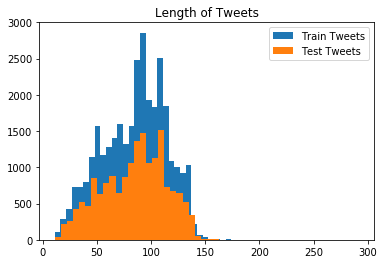

In [7]:
# Check the distribution of length of the tweets, in terms of words, in both train and test data.
train_length = train['tweet'].str.len()
test_length = test['tweet'].str.len()

bins=50
plt.hist(train_length, bins=bins, label="Train Tweets")
plt.hist(test_length, bins=bins, label="Test Tweets")

plt.title('Length of Tweets')
plt.legend()
plt.show()

### Data Cleaning
The objective of this step is to clean noise those are less relevant to find the sentiment of tweets such as punctuation, special characters, numbers, and terms which don’t carry much weightage in context to the text.

In [8]:
# Combine the train and test dataset
combi = train.append(test, ignore_index=True, sort=False)
combi.shape

(49159, 3)

In [9]:
# Function to remove unwanted text patterns from the tweets
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

We will be following the steps below to clean the raw tweets in out data.

1. We will remove the twitter handles as they are already masked as @user due to privacy concerns. These twitter handles hardly give any information about the nature of the tweet.

2. We will also get rid of the punctuations, numbers and even special characters since they wouldn’t help in differentiating different types of tweets.

3. Most of the smaller words do not add much value. For example, ‘pdx’, ‘his’, ‘all’. So, we will try to remove them as well from our data.

4. Lastly, we will normalize the text data. For example, reducing terms like loves, loving, and lovable to their base word, i.e., ‘love’.are often used in the same context. If we can reduce them to their root word, which is ‘love’. It will help in reducing the total number of unique words in our data without losing a significant amount of information.

In [10]:
# 1. Removing Twitter Handles (@user)
# Store cleaned and proecssed tweets in new columns tidy_tweet
#combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "@[\w]*")
#combi['tidy_tweet'] = combi['tweet'].apply(remove_pattern, pattern='@[\w]*')
func = np.vectorize(remove_pattern)
combi['tidy_tweet'] = func(combi['tweet'], "@[\w]*")
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


In [11]:
# 2. Removing Punctuations, Numbers, and Special Characters
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]", " ") 
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can t use cause they don t offer wheelchair vans in pdx #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in ur
4,5,0.0,factsguide: society now #motivation,factsguide society now #motivation


In [12]:
# 3. Removing Short Words
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x : ' '.join([w for w in x.split() if len(w)>3]))
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunctional selfish drags kids into dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks #lyft credit cause they offer wheelchair vans #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


In [13]:
# 4. Text Normalization
# 4a. Tokenize tweets
tokenized_tweets = combi['tidy_tweet'].apply(lambda x : x.split())
tokenized_tweets.head()

0                [when, father, dysfunctional, selfish, drags, kids, into, dysfunction, #run]
1    [thanks, #lyft, credit, cause, they, offer, wheelchair, vans, #disapointed, #getthanked]
2                                                                     [bihday, your, majesty]
3                                                            [#model, love, take, with, time]
4                                                          [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

In [14]:
# 4b. Normalize the tokenized tweets
from nltk.stem.porter import * 
stemmer = PorterStemmer()
tokenized_tweets = tokenized_tweets.apply(lambda x : [stemmer.stem(i) for i in x])
tokenized_tweets.head()

0                   [when, father, dysfunct, selfish, drag, kid, into, dysfunct, #run]
1    [thank, #lyft, credit, caus, they, offer, wheelchair, van, #disapoint, #getthank]
2                                                              [bihday, your, majesti]
3                                                     [#model, love, take, with, time]
4                                                         [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object

In [15]:
# 4c. Stitch the tokens back together
for i in range(len(tokenized_tweets)):
    tokenized_tweets[i] = ' '.join(tokenized_tweets[i])

combi['tidy_tweet'] = tokenized_tweets
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunct selfish drag kid into dysfunct #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thank #lyft credit caus they offer wheelchair van #disapoint #getthank
2,3,0.0,bihday your majesty,bihday your majesti
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguid societi #motiv


## Story Generation and Visualization from Tweets

### A) Understanding the common words used in the tweets: WordCloud

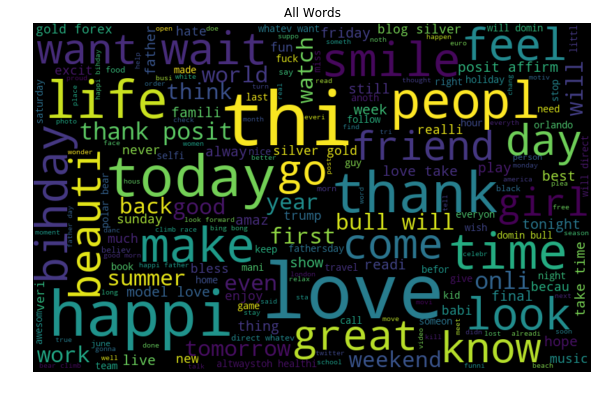

In [16]:
from wordcloud import WordCloud
all_words = ' '.join([text for text in combi['tidy_tweet']]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.title('All Words')
plt.show()

### B) Words in non racist/sexist tweets

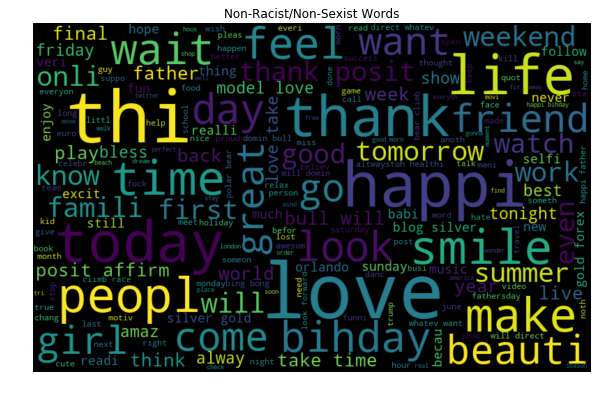

In [17]:
normal_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 0]]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.title('Non-Racist/Non-Sexist Words')
plt.show()

### C) Racist/Sexist Tweets

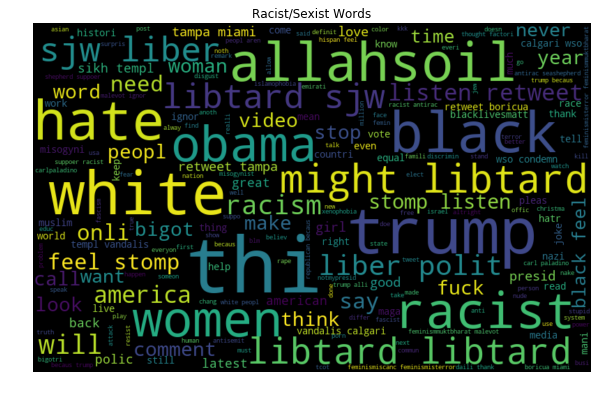

In [18]:
negative_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.title('Racist/Sexist Words')
plt.show()

### D) Understanding the impact of Hashtags on tweets sentiment

In [19]:
# function to collect hashtags 
def hashtag_extract(x):    
    hashtags = []    
    # Loop over the words in the tweet    
    for i in x:        
        ht = re.findall(r"#(\w+)", i)        
        hashtags.append(ht)     
    return hashtags

In [20]:
# extracting hashtags from non racist/sexist tweets 
HT_regular = hashtag_extract(combi['tidy_tweet'][combi['label'] == 0])
# extracting hashtags from racist/sexist tweets 
HT_negative = hashtag_extract(combi['tidy_tweet'][combi['label'] == 1]) 
# unnesting list 
HT_regular = sum(HT_regular,[]) 
HT_negative = sum(HT_negative,[])

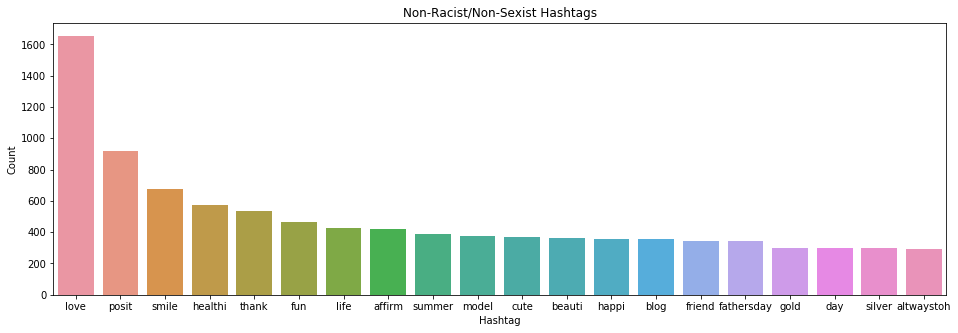

In [21]:
# Non-Racist/Sexist Tweets
a = nltk.FreqDist(HT_regular) 
df_pos = pd.DataFrame({'Hashtag': list(a.keys()), 'Count': list(a.values())}) 

# selecting top 20 most frequent hashtags     
df_pos = df_pos.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5)) 
ax = sns.barplot(data=df_pos, x= "Hashtag", y = "Count") 
ax.set(ylabel = 'Count') 
ax.set_title('Non-Racist/Non-Sexist Hashtags')
plt.show()

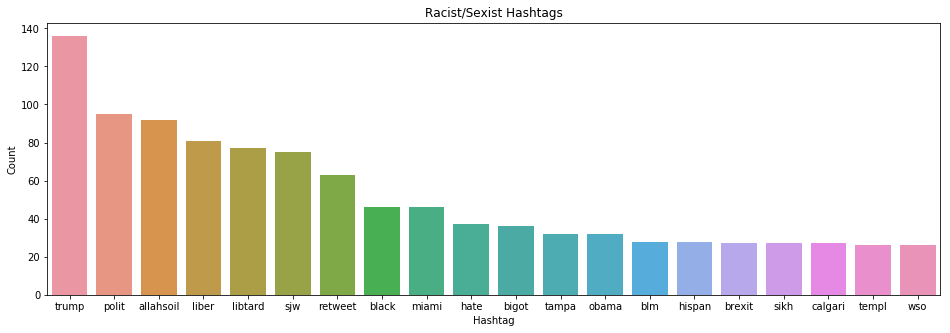

In [22]:
# Racist/Sexist Tweets
b = nltk.FreqDist(HT_negative) 
df_neg = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())}) 

# selecting top 20 most frequent hashtags     
df_neg = df_neg.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5)) 
ax = sns.barplot(data=df_neg, x= "Hashtag", y = "Count") 
ax.set(ylabel = 'Count') 
ax.set_title('Racist/Sexist Hashtags')
plt.show()

## Feature Generation

### Bag-of-Words (CountVectorizer) Features

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english') 
bow = bow_vectorizer.fit_transform(combi['tidy_tweet']) 
bow.shape

(49159, 1000)

### TF-IDF Features
* TF = (Number of times term t appears in a document)/(Number of terms in the document)
* IDF = log(N/n), where, N is the number of documents and n is the number of documents a term t has appeared in.
* TF-IDF = TF*IDF

In [24]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english') 
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet']) 
tfidf.shape

(49159, 1000)

### Word2Vec Features

In [25]:
import gensim

tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split()) # tokenizing 
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34) 

model_w2v.train(tokenized_tweet, total_examples=len(combi['tidy_tweet']), epochs=20)

C:\Softwares_Installed\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


(6510028, 7536020)

In [26]:
# Find similarities - just for fun
model_w2v.wv.most_similar(positive="dinner")

C:\Softwares_Installed\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('spaghetti', 0.5655540823936462),
 ('#avocado', 0.5617824792861938),
 ('melani', 0.5524343252182007),
 ('#biall', 0.5498493313789368),
 ('#cellar', 0.5460770130157471),
 ('spinach', 0.5447607040405273),
 ('gown', 0.5441999435424805),
 ('noodl', 0.5440864562988281),
 ('#bihdaydinn', 0.5439159870147705),
 ('cookout', 0.5439114570617676)]

In [27]:
# Vector representation of any word from our corpus
len(model_w2v['dinner'])

200

In [28]:
# Function to create a vector for each tweet by taking the average of the vectors of the words present in the tweet
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary                                     
            continue
    if count != 0:
        vec /= count
    return vec


# Prepare word2vec feature set
wordvec_arrays = np.zeros((len(tokenized_tweet), 200)) 
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    wordvec_df = pd.DataFrame(wordvec_arrays) 
    
wordvec_df.shape

(49159, 200)

### Doc2Vec Features

In [29]:
from tqdm import tqdm 
tqdm.pandas(desc="progress-bar") 
from gensim.models.doc2vec import LabeledSentence

# Labelise or tag each tokenised tweet with unique IDs
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

# Label all the tweets
labeled_tweets = add_label(tokenized_tweet)

labeled_tweets[:3]

[LabeledSentence(words=['when', 'father', 'dysfunct', 'selfish', 'drag', 'kid', 'into', 'dysfunct', '#run'], tags=['tweet_0']),
 LabeledSentence(words=['thank', '#lyft', 'credit', 'caus', 'they', 'offer', 'wheelchair', 'van', '#disapoint', '#getthank'], tags=['tweet_1']),
 LabeledSentence(words=['bihday', 'your', 'majesti'], tags=['tweet_2'])]

In [30]:
# Train a doc2vec model
model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model                                   
                                  dm_mean=1, # dm = 1 for using mean of the context word vectors                                  
                                  vector_size=200, # no. of desired features                                  
                                  window=5, # width of the context window
                                  negative=7, # if > 0 then negative sampling will be used                                 
                                  min_count=2, # Ignores all words with total frequency lower than 2.                                  
                                  workers=3, # no. of cores                                  
                                  alpha=0.1, # learning rate                                  
                                  seed=34)

model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])
model_d2v.train(labeled_tweets, total_examples= len(combi['tidy_tweet']), epochs=20)

100%|███████████████████████████████████████████████████████████████████████| 49159/49159 [00:00<00:00, 1971485.30it/s]


In [31]:
# Preparing doc2vec Feature Set
docvec_arrays = np.zeros((len(tokenized_tweet), 200)) 
for i in range(len(combi)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,200))    

docvec_df = pd.DataFrame(docvec_arrays) 
docvec_df.shape

(49159, 200)

## Modelling

### Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score

#### With Bag-of-Words features

In [33]:
# We had initially merged the train and test set.
# Now, we are splitting it up again. 
train_bow = bow[:31962,:] 
test_bow = bow[31962:,:] 

# Splitting train data into training and validation set 
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'], random_state=42, test_size=0.3)

# Training the model 
lreg = LogisticRegression() 
lreg.fit(xtrain_bow, ytrain) 
prediction = lreg.predict_proba(xvalid_bow) 

# predicting on the validation set 
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 then 1 else 0 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int) # calculating f1 score for the validation set

C:\Softwares_Installed\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5307820299500832

#### With TF-IDF Features

In [34]:
# We had initially merged the train and test set.
# Now, we are splitting it up again. 
train_tfidf = tfidf[:31962,:] 
test_tfidf = tfidf[31962:,:] 

# Splitting train data into training and validation set 
xtrain_tfidf = train_tfidf[ytrain.index] 
xvalid_tfidf = train_tfidf[yvalid.index]

# Training the model 
lreg = LogisticRegression() 
lreg.fit(xtrain_tfidf, ytrain) 
prediction = lreg.predict_proba(xvalid_tfidf) 

# predicting on the validation set 
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 then 1 else 0 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int) # calculating f1 score for the validation set

C:\Softwares_Installed\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5446507515473032

#### With Word2Vec Features

In [35]:
# We had initially merged the train and test set.
# Now, we are splitting it up again. 
train = wordvec_df.iloc[:31962,:] 
test = wordvec_df.iloc[31962:,:] 

# Splitting train data into training and validation set 
xtrain = train.iloc[ytrain.index] 
xvalid = train.iloc[yvalid.index]

# Training the model 
lreg = LogisticRegression() 
lreg.fit(xtrain, ytrain)
prediction = lreg.predict_proba(xvalid) 

# predicting on the validation set 
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 then 1 else 0 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int) # calculating f1 score for the validation set

C:\Softwares_Installed\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6113989637305699

#### With Doc2Vec Features

In [36]:
# We had initially merged the train and test set.
# Now, we are splitting it up again. 
train = docvec_df.iloc[:31962,:] 
test = docvec_df.iloc[31962:,:] 

# Splitting train data into training and validation set 
xtrain = train.iloc[ytrain.index] 
xvalid = train.iloc[yvalid.index]

# Training the model 
lreg = LogisticRegression() 
lreg.fit(xtrain, ytrain)
prediction = lreg.predict_proba(xvalid) 

# predicting on the validation set 
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 then 1 else 0 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int) # calculating f1 score for the validation set

C:\Softwares_Installed\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.372940156114484

### Following similar approach as above, other classification algos can be tried as well - eg. SVM, Random Forest and XGBoost. XGBoost algo with Word2Vec gives the best score. So we'll finetune it.

In [37]:
import xgboost as xgb

# We had initially merged the train and test set.
# Now, we are splitting it up again. 
train = wordvec_df.iloc[:31962,:] 
test = wordvec_df.iloc[31962:,:] 

# Splitting train data into training and validation set 
xtrain_w2v = train.iloc[ytrain.index] 
xvalid_w2v = train.iloc[yvalid.index]

# DMatrix
dtrain = xgb.DMatrix(xtrain_w2v, label=ytrain) 
dvalid = xgb.DMatrix(xvalid_w2v, label=yvalid) 
#dtest = xgb.DMatrix(test_w2v)

# Parameters that we are going to tune 
params = {
    'objective':'binary:logistic',
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1
 }

# Custom evaluation function to calculate F1 score
def custom_eval(preds, dtrain):
    labels = dtrain.get_label().astype(np.int)
    preds = (preds >= 0.3).astype(np.int)
    return [('f1_score', f1_score(labels, preds))]

#### General Approach for Parameter Tuning
We will follow the steps below to tune the parameters.
1. Choose a relatively high learning rate. Usually a learning rate of 0.3 is used at this stage.
2. Tune tree-specific parameters such as max_depth, min_child_weight, subsample, colsample_bytree keeping the learning rate fixed.
3. Tune the learning rate.
4. Finally tune gamma to avoid overfitting.

In [38]:
# Tuning max_depth and min_child_weight
gridsearch_params = [
                    (max_depth, min_child_weight)
                    for max_depth in range(6,10)
                    for min_child_weight in range(5,8) ]

max_f1 = 0. # initializing with 0 
best_params = None 
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(max_depth, min_child_weight))
    
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    # Cross-validation
    cv_results = xgb.cv(params, dtrain, feval=custom_eval,
                        num_boost_round=200, maximize=True, seed=34, 
                        nfold=5, early_stopping_rounds=10, verbose_eval=1)     

    # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].argmax()
    
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))    
    
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (max_depth, min_child_weight) 

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

CV with max_depth=6, min_child_weight=5
[20:22:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[20:22:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[20:22:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[20:22:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[20:22:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-error:0.0509206+0.000558785	train-f1_score:0.130207+0.00134683	test-error:0.0616812+0.00262274	test-f1_score:0.130192+0.00537341
[20:22:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[20:22:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[20:22:58] src/tree/updater_prune.cc:

[20:23:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[20:23:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[20:23:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[23]	train-error:0.0208956+0.000945059	train-f1_score:0.877787+0.00477172	test-error:0.0460822+0.00305487	test-f1_score:0.641054+0.0157474
[20:23:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[20:23:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[20:23:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[20:23:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[20:23:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra 

[20:23:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[46]	train-error:0.0043912+0.00110296	train-f1_score:0.974105+0.00422755	test-error:0.0421934+0.00247079	test-f1_score:0.649517+0.0110842
[20:23:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[20:23:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[20:23:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[20:23:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[20:23:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[47]	train-error:0.0041232+0.00096788	train-f1_score:0.975759+0.00486929	test-error:0.0422384+0.00218137	test-f1_score:0.651783+0.0100337
[20:23:49] src/tree/updater_prune.cc:74: tree prunin

C:\Softwares_Installed\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


	F1 Score 0.6552764 for 43 rounds
CV with max_depth=6, min_child_weight=6
[20:23:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[20:23:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[20:23:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[20:23:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[20:23:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-error:0.0514124+0.000547159	train-f1_score:0.130207+0.00134683	test-error:0.0621282+0.003035	test-f1_score:0.130192+0.00537341
[20:23:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[20:24:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[20:2

[20:24:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[20:24:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[20:24:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[23]	train-error:0.0220016+0.000607087	train-f1_score:0.875389+0.00265235	test-error:0.0462162+0.00210392	test-f1_score:0.634134+0.00979189
[20:24:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[20:24:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[20:24:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[20:24:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[20:24:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra

[20:24:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[46]	train-error:0.0060118+0.000753435	train-f1_score:0.966516+0.00445279	test-error:0.0431772+0.00222176	test-f1_score:0.65531+0.0112755
[20:24:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[20:24:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[20:24:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[20:24:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[20:24:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[47]	train-error:0.0056092+0.000642417	train-f1_score:0.970134+0.00312116	test-error:0.0432664+0.00257162	test-f1_score:0.65993+0.0104405
[20:24:50] src/tree/updater_prune.cc:74: tree prunin

[20:25:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[20:25:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[20:25:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[20:25:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[20:25:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[70]	train-error:0.0006592+0.000163391	train-f1_score:0.994399+0.000973656	test-error:0.0408078+0.00235278	test-f1_score:0.664181+0.00665313
[20:25:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[20:25:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[20:25:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extr

[20:25:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[20:25:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[20:25:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[20:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[20:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-error:0.0370424+0.000625617	train-f1_score:0.753976+0.0055047	test-error:0.0502386+0.00352124	test-f1_score:0.594082+0.0187649
[20:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[20:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[20:25:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra no

[20:25:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[20:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[20:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[32]	train-error:0.0149622+0.000997142	train-f1_score:0.91575+0.00715334	test-error:0.044518+0.00150945	test-f1_score:0.650978+0.0187295
[20:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[20:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[20:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[20:25:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[20:25:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra no

[20:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[55]	train-error:0.0032406+0.00080802	train-f1_score:0.980201+0.00369817	test-error:0.042149+0.00268084	test-f1_score:0.663836+0.01368
[20:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[20:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[20:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[20:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[20:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[56]	train-error:0.0029052+0.000576207	train-f1_score:0.981695+0.00310766	test-error:0.0418358+0.00254631	test-f1_score:0.666829+0.0128549
[20:26:19] src/tree/updater_prune.cc:74: tree pruning 

[20:26:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=7
[20:26:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=7
[20:26:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[20:26:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=7
[20:26:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=7
[3]	train-error:0.038428+0.000323212	train-f1_score:0.715682+0.00627156	test-error:0.0525186+0.00333455	test-f1_score:0.536853+0.011854
[20:26:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=7
[20:26:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=7
[20:26:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 e

[20:27:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[20:27:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[20:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[26]	train-error:0.0103696+0.000833693	train-f1_score:0.943043+0.00578997	test-error:0.0429088+0.00202066	test-f1_score:0.655723+0.00478746
[20:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[20:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[20:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[20:27:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[20:27:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra

[20:27:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[49]	train-error:0.0006032+0.000184934	train-f1_score:0.993125+0.00119702	test-error:0.0412104+0.00218079	test-f1_score:0.664095+0.019029
[20:27:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[20:27:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[20:27:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[20:27:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[20:27:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[50]	train-error:0.000581+0.00021384	train-f1_score:0.994085+0.00126308	test-error:0.0416126+0.00272507	test-f1_score:0.666459+0.0190554
[20:27:43] src/tree/updater_prune.cc:74: tree pruning

[20:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[20:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[20:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[20:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[20:28:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
	F1 Score 0.6701775999999999 for 63 rounds
CV with max_depth=7, min_child_weight=6
[20:28:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=7
[20:28:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=7
[20:28:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=7
[20:28:11] src/tre

[20:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[20:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[20:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[22]	train-error:0.0154314+0.00053766	train-f1_score:0.917618+0.00312801	test-error:0.045099+0.00165894	test-f1_score:0.633175+0.0106058
[20:28:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[20:28:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[20:28:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[20:28:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[20:28:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra no

[20:29:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[45]	train-error:0.0017208+0.000306922	train-f1_score:0.98758+0.00281045	test-error:0.042149+0.00158177	test-f1_score:0.658931+0.00866495
[20:29:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[20:29:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[20:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[20:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[20:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[46]	train-error:0.0015534+0.0002382	train-f1_score:0.987977+0.00175558	test-error:0.0417018+0.00184375	test-f1_score:0.659852+0.006969
[20:29:10] src/tree/updater_prune.cc:74: tree pruning 

[20:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[20:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[20:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[20:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[20:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[69]	train-error:0.000335+6.13449e-05	train-f1_score:0.997111+0.000531773	test-error:0.0409418+0.00226898	test-f1_score:0.655236+0.00972831
[20:29:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[20:29:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[20:29:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra

[20:30:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[20:30:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[20:30:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[17]	train-error:0.0211862+0.000541815	train-f1_score:0.873674+0.00622613	test-error:0.0459926+0.00305858	test-f1_score:0.632891+0.014947
[20:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[20:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[20:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[20:30:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[20:30:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra n

[20:30:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[40]	train-error:0.0042796+0.000691366	train-f1_score:0.976251+0.00250421	test-error:0.0426408+0.00230915	test-f1_score:0.661728+0.0124172
[20:30:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[20:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[20:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[20:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[20:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[41]	train-error:0.0039+0.000465067	train-f1_score:0.978462+0.00261093	test-error:0.0423724+0.00230522	test-f1_score:0.660522+0.0105902
[20:30:52] src/tree/updater_prune.cc:74: tree pruning

[20:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[20:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[20:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[20:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[20:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[64]	train-error:0.0004022+8.96e-05	train-f1_score:0.996475+0.00106758	test-error:0.0421936+0.00266922	test-f1_score:0.672283+0.016231
[20:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[20:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[20:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra node

[20:32:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[20:32:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[20:32:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[18]	train-error:0.0125932+0.000529406	train-f1_score:0.936426+0.00457793	test-error:0.0440262+0.00249712	test-f1_score:0.639923+0.0139287
[20:32:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[20:32:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[20:32:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[20:32:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[20:32:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra 

[20:32:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[41]	train-error:0.000648+7.54904e-05	train-f1_score:0.994083+0.00129131	test-error:0.0415678+0.00193077	test-f1_score:0.662438+0.0161841
[20:32:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[20:32:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[20:32:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[20:32:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[20:32:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[42]	train-error:0.0005474+0.00012927	train-f1_score:0.994799+0.00115135	test-error:0.0414786+0.00163766	test-f1_score:0.662792+0.0158334
[20:32:41] src/tree/updater_prune.cc:74: tree prunin

[20:33:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[20:33:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[20:33:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[20:33:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[20:33:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[65]	train-error:0.000335+6.13449e-05	train-f1_score:0.997274+0.000521986	test-error:0.0407634+0.0023862	test-f1_score:0.666512+0.0174296
[20:33:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[20:33:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[20:33:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra n

[20:33:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[20:33:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[20:33:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=8
[16]	train-error:0.015264+0.000979942	train-f1_score:0.919754+0.00268639	test-error:0.044741+0.00267185	test-f1_score:0.643689+0.0133924
[20:33:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[20:33:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[20:33:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[20:33:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[20:33:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra no

[20:34:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[39]	train-error:0.0012628+0.000265759	train-f1_score:0.99011+0.00234926	test-error:0.0420144+0.00288975	test-f1_score:0.661548+0.0178261
[20:34:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[20:34:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[20:34:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[20:34:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[20:34:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[40]	train-error:0.0012292+0.000244695	train-f1_score:0.990979+0.00162638	test-error:0.0417018+0.00241436	test-f1_score:0.660455+0.0129194
[20:34:31] src/tree/updater_prune.cc:74: tree pruni

[20:35:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=8
[20:35:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=8
[20:35:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=8
[20:35:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=8
[20:35:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=8
[9]	train-error:0.0260916+0.00146628	train-f1_score:0.852698+0.00784252	test-error:0.0479594+0.00288864	test-f1_score:0.606195+0.0146781
[20:35:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=8
[20:35:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=8
[20:35:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 

[20:35:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[20:35:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[20:35:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[32]	train-error:0.0045368+0.000485941	train-f1_score:0.975457+0.00149785	test-error:0.0429982+0.00250014	test-f1_score:0.661355+0.0120514
[20:35:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[20:35:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[20:35:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[20:35:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[20:35:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra 

[20:36:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[9]	train-error:0.0190184+0.000634481	train-f1_score:0.905766+0.00578657	test-error:0.0460374+0.00259441	test-f1_score:0.615532+0.016615
[20:36:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[20:36:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[20:36:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[20:36:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[20:36:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[10]	train-error:0.0178118+0.000805027	train-f1_score:0.914261+0.00418215	test-error:0.0459928+0.002259	test-f1_score:0.623097+0.0197136
[20:36:15] src/tree/updater_prune.cc:74: tree pr

[20:36:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[20:36:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[20:36:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[20:36:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[20:36:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[33]	train-error:0.0007264+0.000154019	train-f1_score:0.993604+0.000898823	test-error:0.0411656+0.00255092	test-f1_score:0.664516+0.0101544
[20:36:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[20:36:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[20:36:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra

[20:37:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=9
[20:37:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=9
[20:37:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=9
[20:37:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=9
[20:37:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=9
[1]	train-error:0.0385508+0.00046486	train-f1_score:0.515348+0.0152583	test-error:0.0563178+0.00236454	test-f1_score:0.408445+0.0243102
[20:37:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=9
[20:37:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=9
[20:37:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 e

[20:37:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[20:37:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[20:37:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[24]	train-error:0.0054418+0.000447497	train-f1_score:0.972468+0.00157065	test-error:0.0432662+0.00262827	test-f1_score:0.648165+0.0167721
[20:37:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[20:37:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[20:37:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[20:37:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[20:37:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra 

[20:38:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[47]	train-error:0.0003462+6.53067e-05	train-f1_score:0.99703+0.000543167	test-error:0.0412998+0.0020958	test-f1_score:0.661908+0.0145455
[20:38:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=9
[20:38:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[20:38:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[20:38:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[20:38:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[48]	train-error:0.000335+6.13449e-05	train-f1_score:0.997351+0.000405963	test-error:0.0413892+0.00250422	test-f1_score:0.662866+0.0160456
[20:38:21] src/tree/updater_prune.cc:74: tree pruni

[20:38:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[20:38:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[20:38:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[20:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[20:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[10]	train-error:0.0218566+0.000665657	train-f1_score:0.886543+0.00339024	test-error:0.0469314+0.00354782	test-f1_score:0.625134+0.0123141
[20:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[20:38:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[20:38:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12

[20:39:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[20:39:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[20:39:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[33]	train-error:0.0019+3.54175e-05	train-f1_score:0.988373+0.00221942	test-error:0.0415678+0.00231579	test-f1_score:0.661731+0.0117802
[20:39:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[20:39:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[20:39:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[20:39:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[20:39:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nod

In [39]:
# Updating max_depth and min_child_weight parameters
params['max_depth'] = 8 
params['min_child_weight'] = 6

# Tuning subsample and colsample
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(5,10)]
    for colsample in [i/10. for i in range(5,10)] ]

max_f1 = 0. 
best_params = None 
for subsample, colsample in gridsearch_params:
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
     # Update our parameters
    params['colsample'] = colsample
    params['subsample'] = subsample
    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=200,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=10, verbose_eval=1
    )
     # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].argmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (subsample, colsample) 

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

CV with subsample=0.5, colsample=0.5
[20:39:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=8
[20:39:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=8
[20:39:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=8
[20:39:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=8
[20:39:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=8
[0]	train-error:0.05824+0.00265465	train-f1_score:0.130208+0.00076432	test-error:0.0667322+0.00697628	test-f1_score:0.130202+0.00306266
[20:39:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=8
[20:39:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=8
[20:39:42] src/tree/updater_prune.cc:74

[20:40:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[20:40:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[20:40:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[23]	train-error:0.0200016+0.000625617	train-f1_score:0.87107+0.00340052	test-error:0.04492+0.00236849	test-f1_score:0.631072+0.0228654
[20:40:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[20:40:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[20:40:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[20:40:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[20:40:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nod

[20:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[46]	train-error:0.006939+0.000715801	train-f1_score:0.961133+0.00354925	test-error:0.0438026+0.0021918	test-f1_score:0.65093+0.0222257
[20:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[20:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[20:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[20:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[20:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[47]	train-error:0.0065814+0.000580024	train-f1_score:0.962684+0.00213587	test-error:0.0434452+0.0023019	test-f1_score:0.651494+0.0192773
[20:40:33] src/tree/updater_prune.cc:74: tree pruning 

[20:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[20:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[20:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[20:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[20:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[70]	train-error:0.0017096+0.000270586	train-f1_score:0.989386+0.00229441	test-error:0.0426406+0.00260612	test-f1_score:0.66058+0.0172384
[20:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[20:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[20:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra n

C:\Softwares_Installed\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


	F1 Score 0.6632434 for 79 rounds
CV with subsample=0.5, colsample=0.6
[20:41:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=8
[20:41:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=8
[20:41:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=8
[20:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=8
[20:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=8
[0]	train-error:0.05824+0.00265465	train-f1_score:0.130208+0.00076432	test-error:0.0667322+0.00697628	test-f1_score:0.130202+0.00306266
[20:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=8
[20:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=8
[20:4

[20:41:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[20:41:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[20:41:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[20:41:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[23]	train-error:0.0200016+0.000625617	train-f1_score:0.87107+0.00340052	test-error:0.04492+0.00236849	test-f1_score:0.631072+0.0228654
[20:41:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[20:41:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[20:41:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[20:41:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nod

[20:41:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[20:41:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[20:41:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[20:41:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[20:41:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[35]	train-error:0.0122132+0.000627741	train-f1_score:0.929237+0.00273151	test-error:0.0436688+0.00200628	test-f1_score:0.642165+0.0180086
[20:41:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[20:41:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[20:41:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra 

[20:42:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[20:42:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[20:42:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[58]	train-error:0.0035868+0.000320539	train-f1_score:0.979092+0.00159813	test-error:0.0421936+0.00204903	test-f1_score:0.656544+0.0123673
[20:42:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[20:42:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[20:42:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[20:42:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[20:42:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra 

[20:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[81]	train-error:0.0009274+0.000120312	train-f1_score:0.993515+0.00127199	test-error:0.0419704+0.00305093	test-f1_score:0.66186+0.0175983
[20:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[20:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[20:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[20:42:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[20:42:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[82]	train-error:0.0008938+0.000145724	train-f1_score:0.993521+0.00170185	test-error:0.0419702+0.00307111	test-f1_score:0.656883+0.0160652
[20:42:23] src/tree/updater_prune.cc:74: tree pruni

[20:42:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[20:42:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[20:42:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[20:42:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[20:42:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[15]	train-error:0.0281368+0.000256756	train-f1_score:0.811813+0.00319579	test-error:0.0476468+0.00269057	test-f1_score:0.616712+0.0198396
[20:42:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[20:42:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[20:42:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra 

[20:42:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[20:42:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[20:43:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[38]	train-error:0.0101572+0.000551067	train-f1_score:0.93816+0.0041205	test-error:0.0435794+0.00204191	test-f1_score:0.646778+0.0186941
[20:43:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[20:43:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[20:43:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[20:43:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[20:43:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra no

[20:43:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[61]	train-error:0.0031176+0.000248564	train-f1_score:0.982015+0.00277764	test-error:0.0420148+0.00221912	test-f1_score:0.65915+0.0166834
[20:43:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[20:43:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[20:43:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[20:43:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[20:43:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[62]	train-error:0.0027826+0.00025807	train-f1_score:0.982651+0.00226119	test-error:0.042283+0.00217986	test-f1_score:0.659184+0.0178875
[20:43:16] src/tree/updater_prune.cc:74: tree pruning

[20:43:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[20:43:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[20:43:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[20:43:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[20:43:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[85]	train-error:0.0006928+0.000134933	train-f1_score:0.99408+0.00136957	test-error:0.0420146+0.00321003	test-f1_score:0.65973+0.0185348
[20:43:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[20:43:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[20:43:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra no

[20:43:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[20:43:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=8
[20:43:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=8
[20:43:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[20:43:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=8
[7]	train-error:0.0380146+0.000391122	train-f1_score:0.738975+0.00478344	test-error:0.0525186+0.00239499	test-f1_score:0.561556+0.0261771
[20:43:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=8
[20:43:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[20:43:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra n

[20:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[20:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[20:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[30]	train-error:0.015152+0.00072366	train-f1_score:0.907958+0.00473979	test-error:0.0438922+0.00248224	test-f1_score:0.642417+0.00980765
[20:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[20:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[20:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[20:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[20:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra n

[20:44:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[53]	train-error:0.0048608+0.000494558	train-f1_score:0.973843+0.00291759	test-error:0.0427748+0.00207963	test-f1_score:0.654836+0.0210867
[20:44:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[20:44:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[20:44:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[20:44:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[20:44:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[54]	train-error:0.0044586+0.000566765	train-f1_score:0.975017+0.0021886	test-error:0.0427302+0.00247289	test-f1_score:0.654749+0.0194576
[20:44:13] src/tree/updater_prune.cc:74: tree pruni

[20:44:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[20:44:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[20:44:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[20:44:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[20:44:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[77]	train-error:0.0010728+0.000147314	train-f1_score:0.991605+0.00134004	test-error:0.04197+0.00320378	test-f1_score:0.661129+0.0167948
[20:44:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[20:44:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[20:44:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra no

[20:44:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=8
[20:44:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[20:44:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=8
[10]	train-error:0.0337462+0.00123119	train-f1_score:0.77169+0.00271594	test-error:0.0501494+0.00172002	test-f1_score:0.59196+0.0235634
[20:44:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[20:44:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[20:44:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[20:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[20:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nod

[20:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[33]	train-error:0.0131518+0.000453216	train-f1_score:0.922392+0.00479724	test-error:0.0443392+0.00195997	test-f1_score:0.635748+0.0149203
[20:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[20:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[20:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[20:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[20:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[34]	train-error:0.0124816+0.000501445	train-f1_score:0.924671+0.00331503	test-error:0.0437582+0.00200473	test-f1_score:0.636164+0.0141112
[20:45:00] src/tree/updater_prune.cc:74: tree prun

[20:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[20:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[20:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[20:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[20:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[57]	train-error:0.0038328+0.000409988	train-f1_score:0.977445+0.00255245	test-error:0.0423278+0.00224423	test-f1_score:0.656951+0.0137969
[20:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[20:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[20:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra 

[20:45:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[20:45:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[20:45:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[80]	train-error:0.0009834+0.000152352	train-f1_score:0.993199+0.00142647	test-error:0.042149+0.00262181	test-f1_score:0.662067+0.0155678
[20:45:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[20:45:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[20:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[20:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[20:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra n

[20:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[13]	train-error:0.0268402+0.00100729	train-f1_score:0.830304+0.00756254	test-error:0.048362+0.00215993	test-f1_score:0.600559+0.01948
[20:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[20:45:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[20:45:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[20:45:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[20:45:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[14]	train-error:0.0259016+0.000870278	train-f1_score:0.837589+0.00449657	test-error:0.048049+0.00235266	test-f1_score:0.609845+0.0189962
[20:45:49] src/tree/updater_prune.cc:74: tree pruning e

[20:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[20:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[20:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[20:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[20:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[37]	train-error:0.0073082+0.000586586	train-f1_score:0.957905+0.00538532	test-error:0.0431326+0.0023951	test-f1_score:0.645952+0.0257799
[20:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[20:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[20:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra n

[20:46:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[20:46:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[20:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[60]	train-error:0.001352+0.000300663	train-f1_score:0.991533+0.00186881	test-error:0.0419706+0.00366041	test-f1_score:0.66179+0.0260067
[20:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[20:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[20:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[20:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[20:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra no

[20:46:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[83]	train-error:0.0004358+0.000108588	train-f1_score:0.996316+0.000662005	test-error:0.0424622+0.00340854	test-f1_score:0.662628+0.019407
[20:46:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[20:46:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[20:46:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[20:46:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[20:46:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[84]	train-error:0.0004022+0.000114218	train-f1_score:0.996399+0.000988475	test-error:0.0427302+0.00338015	test-f1_score:0.661109+0.0196067
[20:46:52] src/tree/updater_prune.cc:74: tree pru

[20:47:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[20:47:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[20:47:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[20:47:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[20:47:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[21]	train-error:0.0188172+0.000892355	train-f1_score:0.884062+0.00550504	test-error:0.0457248+0.00253956	test-f1_score:0.627015+0.024109
[20:47:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[20:47:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[20:47:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra n

[20:47:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[20:47:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[20:47:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[44]	train-error:0.0046486+0.000446172	train-f1_score:0.973678+0.00389328	test-error:0.042596+0.00241738	test-f1_score:0.652666+0.0324299
[20:47:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[20:47:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[20:47:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[20:47:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[20:47:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra n

[20:47:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[67]	train-error:0.0008938+0.000169593	train-f1_score:0.993374+0.0020748	test-error:0.0422832+0.00374709	test-f1_score:0.664972+0.018544
[20:47:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[20:47:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[20:47:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[20:47:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[20:47:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[68]	train-error:0.0008718+0.000156472	train-f1_score:0.993607+0.00148207	test-error:0.0422384+0.00349776	test-f1_score:0.667655+0.0200435
[20:47:46] src/tree/updater_prune.cc:74: tree prunin

[20:48:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=8
[20:48:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=8
[20:48:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=8
[20:48:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=8
[20:48:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=8
[5]	train-error:0.0379588+0.000922569	train-f1_score:0.736317+0.00853924	test-error:0.0524738+0.000830267	test-f1_score:0.553796+0.0260054
[20:48:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=8
[20:48:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=8
[20:48:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 11

[20:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[20:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[20:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[28]	train-error:0.0130068+0.000922551	train-f1_score:0.923359+0.00430003	test-error:0.0455012+0.00244202	test-f1_score:0.63899+0.0261952
[20:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[20:48:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[20:48:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[20:48:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[20:48:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra n

[20:48:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[51]	train-error:0.0027492+0.000339562	train-f1_score:0.984869+0.00199197	test-error:0.0428642+0.00243832	test-f1_score:0.652896+0.0295452
[20:48:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[20:48:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[20:48:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[20:48:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[20:48:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[52]	train-error:0.0024468+0.000339562	train-f1_score:0.984882+0.00217771	test-error:0.0434006+0.00246639	test-f1_score:0.656413+0.0298176
[20:48:39] src/tree/updater_prune.cc:74: tree prun

[20:48:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[20:48:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[20:48:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[20:48:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[20:48:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[75]	train-error:0.0005696+0.000194797	train-f1_score:0.995519+0.000856958	test-error:0.0421046+0.00346781	test-f1_score:0.668993+0.0201574
[20:48:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=8
[20:48:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[20:48:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra

[20:49:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=8
[20:49:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=8
[20:49:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=8
[20:49:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=8
[20:49:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=8
[1]	train-error:0.0472556+0.00104999	train-f1_score:0.462779+0.0100642	test-error:0.0573014+0.00144771	test-f1_score:0.389817+0.019272
[20:49:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=8
[20:49:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=8
[20:49:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 ex

[20:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[20:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[20:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[24]	train-error:0.0162584+0.000871003	train-f1_score:0.903025+0.00527472	test-error:0.045546+0.00295343	test-f1_score:0.634874+0.0307953
[20:49:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[20:49:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[20:49:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[20:49:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[20:49:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra n

[20:49:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[47]	train-error:0.0037656+0.000305195	train-f1_score:0.978468+0.00310282	test-error:0.0430876+0.00292651	test-f1_score:0.652484+0.026758
[20:49:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[20:49:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[20:49:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[20:49:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[20:49:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[48]	train-error:0.0035088+0.000210142	train-f1_score:0.980436+0.0034157	test-error:0.0434008+0.0026497	test-f1_score:0.6542+0.0242983
[20:49:40] src/tree/updater_prune.cc:74: tree pruning e

[20:49:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[20:49:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[20:49:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[20:49:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[20:49:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[71]	train-error:0.0006706+0.000183609	train-f1_score:0.994163+0.00125982	test-error:0.042328+0.00346209	test-f1_score:0.666418+0.0174209
[20:49:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[20:49:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[20:49:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra n

[20:50:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=8
[20:50:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=8
[20:50:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=8
[8]	train-error:0.033869+0.000413054	train-f1_score:0.775967+0.00555317	test-error:0.051446+0.00147018	test-f1_score:0.573299+0.0215808
[20:50:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=8
[20:50:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=8
[20:50:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=8
[20:50:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[20:50:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra n

[20:50:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[31]	train-error:0.0107942+0.000830783	train-f1_score:0.936011+0.0043961	test-error:0.043937+0.00265399	test-f1_score:0.640571+0.025958
[20:50:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[20:50:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[20:50:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[20:50:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[20:50:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[32]	train-error:0.009878+0.000904197	train-f1_score:0.939884+0.00298823	test-error:0.0440264+0.00205902	test-f1_score:0.643595+0.0204445
[20:50:32] src/tree/updater_prune.cc:74: tree pruning 

[20:50:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[20:50:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[20:50:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[20:50:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[20:50:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[55]	train-error:0.0020224+0.000383047	train-f1_score:0.988521+0.00169314	test-error:0.0428642+0.00305257	test-f1_score:0.654276+0.0287817
[20:50:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[20:50:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[20:50:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra 

[20:51:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[20:51:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[20:51:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[78]	train-error:0.0004916+0.000129373	train-f1_score:0.995997+0.000685401	test-error:0.0424622+0.00357956	test-f1_score:0.665242+0.0192477
[20:51:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[20:51:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[20:51:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[20:51:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[20:51:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra

[20:51:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[15]	train-error:0.0229628+0.000249904	train-f1_score:0.864213+0.00362008	test-error:0.0471548+0.00198157	test-f1_score:0.627935+0.017577
[20:51:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[20:51:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[20:51:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[20:51:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[20:51:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[16]	train-error:0.0217226+0.000281961	train-f1_score:0.872084+0.00374567	test-error:0.046976+0.00226526	test-f1_score:0.631449+0.0161464
[20:51:24] src/tree/updater_prune.cc:74: tree prunin

[20:51:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[20:51:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[20:51:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[20:51:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[20:51:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[39]	train-error:0.0045592+0.000343706	train-f1_score:0.975582+0.00177363	test-error:0.0430876+0.00263468	test-f1_score:0.645864+0.0276997
[20:51:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[20:51:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[20:51:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra 

[20:52:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[20:52:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[20:52:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[17]	train-error:0.0207616+0.000270835	train-f1_score:0.88202+0.00501466	test-error:0.0471994+0.00205752	test-f1_score:0.634275+0.0129198
[20:52:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[20:52:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[20:52:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[20:52:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[20:52:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra n

[20:52:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[40]	train-error:0.0040788+0.000199681	train-f1_score:0.977112+0.00120939	test-error:0.0430876+0.00312037	test-f1_score:0.647526+0.0300236
[20:52:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[20:52:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[20:52:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[20:52:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[20:52:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[41]	train-error:0.0037434+0.000310355	train-f1_score:0.978993+0.00171355	test-error:0.0431768+0.00260013	test-f1_score:0.646214+0.0273146
[20:52:25] src/tree/updater_prune.cc:74: tree prun

[20:52:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[20:52:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[20:52:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[20:52:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[20:52:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[19]	train-error:0.0181804+0.000454986	train-f1_score:0.89424+0.00403933	test-error:0.0457248+0.00208351	test-f1_score:0.630471+0.0150722
[20:52:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[20:52:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[20:52:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra n

[20:53:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[20:53:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[20:53:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[42]	train-error:0.0034418+0.000198781	train-f1_score:0.981758+0.00139328	test-error:0.0432664+0.002728	test-f1_score:0.64562+0.0260068
[20:53:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[20:53:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[20:53:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[20:53:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[20:53:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nod

[20:53:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[20]	train-error:0.017186+0.000416261	train-f1_score:0.902791+0.00196059	test-error:0.0450544+0.00147856	test-f1_score:0.637515+0.0131509
[20:53:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[20:53:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[20:53:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[20:53:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[20:53:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[21]	train-error:0.015789+0.00024631	train-f1_score:0.907427+0.0024404	test-error:0.0448308+0.00166437	test-f1_score:0.629981+0.00939154
[20:53:27] src/tree/updater_prune.cc:74: tree pruning

[20:53:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[20:53:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[20:53:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[20:53:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[20:53:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
	F1 Score 0.6480632 for 34 rounds
CV with subsample=0.7, colsample=0.9
[20:53:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=8
[20:53:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=8
[20:53:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=8
[20:53:48] src/tree/updater_pru

[20:54:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[20:54:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[20:54:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[22]	train-error:0.0149288+0.000518845	train-f1_score:0.914016+0.00468928	test-error:0.0451436+0.00123923	test-f1_score:0.634738+0.00823756
[20:54:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[20:54:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[20:54:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[20:54:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[20:54:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra

[20:54:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=8
[20:54:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=8
[20:54:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=8
[20:54:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=8
[20:54:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=8
[1]	train-error:0.0445514+0.000911036	train-f1_score:0.465755+0.0138857	test-error:0.056318+0.00347195	test-f1_score:0.391277+0.0131572
[20:54:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=8
[20:54:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=8
[20:54:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 e

[20:54:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[20:54:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[20:54:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[24]	train-error:0.0120122+0.000819279	train-f1_score:0.936266+0.00625555	test-error:0.0430876+0.00278006	test-f1_score:0.661892+0.0184345
[20:54:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[20:54:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[20:54:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[20:54:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[20:54:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra 

[20:55:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=8
[20:55:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=8
[20:55:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=8
[20:55:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=8
[20:55:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=8
[3]	train-error:0.0395008+0.000991672	train-f1_score:0.704966+0.00894598	test-error:0.0527866+0.00227078	test-f1_score:0.533181+0.0208661
[20:55:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=8
[20:55:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=8
[20:55:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162

[20:55:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[20:55:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[20:55:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[26]	train-error:0.0106154+0.000865275	train-f1_score:0.946333+0.00596048	test-error:0.0425514+0.00289041	test-f1_score:0.663612+0.0215564
[20:55:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[20:55:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[20:55:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=8
[20:55:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[20:55:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra 

[20:56:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=8
[20:56:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=8
[20:56:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=8
[20:56:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=8
[20:56:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=8
[5]	train-error:0.0349082+0.000625346	train-f1_score:0.770057+0.00396698	test-error:0.0512224+0.00264861	test-f1_score:0.577083+0.0180685
[20:56:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=8
[20:56:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=8
[20:56:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140

[20:56:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[20:56:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[20:56:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[28]	train-error:0.008984+0.000740867	train-f1_score:0.954063+0.00622299	test-error:0.0415682+0.00278661	test-f1_score:0.664826+0.0184922
[20:56:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[20:56:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[20:56:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[20:56:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[20:56:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra n

[20:56:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=8
[6]	train-error:0.0330866+0.000601058	train-f1_score:0.788581+0.00572436	test-error:0.0502392+0.00358733	test-f1_score:0.587084+0.0207043
[20:56:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=8
[20:56:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=8
[20:56:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=8
[20:56:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=8
[20:56:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=8
[7]	train-error:0.0316228+0.000692895	train-f1_score:0.807186+0.00789602	test-error:0.0501496+0.00311893	test-f1_score:0.5936+0.0189857
[20:56:48] src/tree/updater_prune.cc:74: tree pr

[20:57:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[20:57:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[20:57:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[20:57:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[20:57:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[30]	train-error:0.0075986+0.000444235	train-f1_score:0.962855+0.00386367	test-error:0.0421042+0.00235761	test-f1_score:0.668636+0.0259276
[20:57:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[20:57:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[20:57:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra 

[20:57:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=8
[20:57:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=8
[20:57:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=8
[8]	train-error:0.0302822+0.000736066	train-f1_score:0.817774+0.00611914	test-error:0.0492558+0.00342093	test-f1_score:0.613274+0.0185974
[20:57:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=8
[20:57:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[20:57:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=8
[20:57:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[20:57:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 ex

[20:57:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[31]	train-error:0.0070174+0.000288713	train-f1_score:0.966275+0.00361209	test-error:0.0418362+0.00229229	test-f1_score:0.671166+0.0220928
[20:57:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[20:57:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[20:57:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[20:57:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[20:57:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[32]	train-error:0.0064474+0.000296989	train-f1_score:0.968057+0.00364606	test-error:0.04197+0.00278388	test-f1_score:0.671782+0.0255734
[20:57:53] src/tree/updater_prune.cc:74: tree prunin

[20:58:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=8
[20:58:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=8
[20:58:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=8
[20:58:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=8
[20:58:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=8
[10]	train-error:0.0241362+0.00072808	train-f1_score:0.861784+0.00353555	test-error:0.0469762+0.001144	test-f1_score:0.611157+0.0127799
[20:58:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=8
[20:58:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[20:58:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 ex

[20:58:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[20:58:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[20:58:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[33]	train-error:0.0038102+0.00055116	train-f1_score:0.980685+0.00325789	test-error:0.0422386+0.00294678	test-f1_score:0.655841+0.0230097
[20:58:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[20:58:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[20:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[20:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[20:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra n

[20:59:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[13]	train-error:0.0204936+0.000544634	train-f1_score:0.882483+0.00542493	test-error:0.0460376+0.00145958	test-f1_score:0.629264+0.0122322
[20:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=8
[20:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[20:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[20:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=8
[20:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=8
[14]	train-error:0.019376+0.00065426	train-f1_score:0.891728+0.00681783	test-error:0.0457246+0.00229755	test-f1_score:0.627974+0.00892173
[20:59:05] src/tree/updater_prune.cc:74: tree pruni

[20:59:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[20:59:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[20:59:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[20:59:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[20:59:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[37]	train-error:0.0024136+0.000593858	train-f1_score:0.986304+0.00264904	test-error:0.042015+0.0032617	test-f1_score:0.650858+0.0186072
[20:59:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[20:59:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[20:59:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra no

[20:59:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[20:59:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[20:59:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[17]	train-error:0.0167502+0.000819441	train-f1_score:0.90738+0.00672183	test-error:0.0455458+0.00305135	test-f1_score:0.633523+0.0159483
[20:59:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[20:59:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[20:59:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[20:59:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[20:59:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra n

[21:00:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[40]	train-error:0.0016316+0.000379458	train-f1_score:0.990019+0.00234561	test-error:0.0412102+0.00322689	test-f1_score:0.655001+0.0179399
[21:00:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[21:00:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[21:00:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[21:00:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[21:00:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[41]	train-error:0.0014638+0.000382773	train-f1_score:0.990653+0.00223208	test-error:0.0416124+0.00326322	test-f1_score:0.652089+0.0162643
[21:00:12] src/tree/updater_prune.cc:74: tree prun

[21:00:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[21:00:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=8
[21:00:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[21:00:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[21:00:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[21]	train-error:0.0126714+0.000810331	train-f1_score:0.934155+0.00520235	test-error:0.0446968+0.00279832	test-f1_score:0.644859+0.0231057
[21:00:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[21:00:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[21:00:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra 

[21:00:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=8
[21:00:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=8
[21:00:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=8
[1]	train-error:0.0427302+0.00191753	train-f1_score:0.493053+0.00892504	test-error:0.0563624+0.00380503	test-f1_score:0.405816+0.0138217
[21:00:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=8
[21:00:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=8
[21:00:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=8
[21:00:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=8
[21:00:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 

[21:01:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[24]	train-error:0.009867+0.000659831	train-f1_score:0.948752+0.00355814	test-error:0.0435792+0.00278593	test-f1_score:0.646015+0.0179777
[21:01:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[21:01:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[21:01:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[21:01:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[21:01:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[25]	train-error:0.0092298+0.00078171	train-f1_score:0.952326+0.00313535	test-error:0.0434454+0.00309788	test-f1_score:0.643733+0.0189916
[21:01:21] src/tree/updater_prune.cc:74: tree prunin

In [40]:
# Updating subsample and colsample_bytree
params['subsample'] = .9 
params['colsample_bytree'] = .5

# Now let’s tune the learning rate.
max_f1 = 0. 
best_params = None 
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
     # Update ETA
    params['eta'] = eta

     # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=1000,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=20, verbose_eval=1
    )

     # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].argmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = eta 
print("Best params: {}, F1 Score: {}".format(best_params, max_f1))

CV with eta=0.3
[21:01:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=8
[21:01:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=8
[21:01:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=8
[21:01:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=8
[21:01:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=8
[0]	train-error:0.0518258+0.00132536	train-f1_score:0.130208+0.00076432	test-error:0.0667768+0.00289095	test-f1_score:0.130202+0.00306266
[21:01:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=8
[21:01:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=8
[21:01:39] src/tree/updater_prune.cc:74: tree pruning e

[21:01:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[21:01:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[21:01:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[23]	train-error:0.0118894+0.000235031	train-f1_score:0.940736+0.00645853	test-error:0.0444286+0.00137731	test-f1_score:0.645873+0.0211499
[21:01:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[21:01:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[21:01:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[21:01:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[21:01:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra 

[21:02:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[46]	train-error:0.001095+0.00021384	train-f1_score:0.993123+0.000661162	test-error:0.0413444+0.0017807	test-f1_score:0.666175+0.0212146
[21:02:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[21:02:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[21:02:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[21:02:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[21:02:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[47]	train-error:0.0009498+0.000257496	train-f1_score:0.993759+0.000513872	test-error:0.0412996+0.00182113	test-f1_score:0.669149+0.0254892
[21:02:03] src/tree/updater_prune.cc:74: tree pruni

[21:02:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[21:02:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[21:02:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[21:02:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[21:02:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[70]	train-error:0.000335+6.13449e-05	train-f1_score:0.997355+0.0005269	test-error:0.040808+0.00208942	test-f1_score:0.672748+0.0298561
[21:02:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[21:02:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[21:02:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nod

C:\Softwares_Installed\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


	F1 Score 0.6767224 for 65 rounds
CV with eta=0.2
[21:02:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=8
[21:02:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=8
[21:02:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=8
[21:02:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=8
[21:02:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=8
[0]	train-error:0.0518258+0.00132536	train-f1_score:0.130208+0.00076432	test-error:0.0667768+0.00289095	test-f1_score:0.130202+0.00306266
[21:02:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=8
[21:02:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=8
[21:02:22] src/tree/u

[21:02:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=8
[21:02:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=8
[21:02:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[21:02:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[23]	train-error:0.0192308+0.000571893	train-f1_score:0.899509+0.00285592	test-error:0.0461268+0.00204747	test-f1_score:0.623653+0.0259424
[21:02:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[21:02:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[21:02:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=8
[21:02:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 ext

[21:02:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[21:02:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[21:02:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[21:02:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[21:02:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[35]	train-error:0.0115206+0.000592405	train-f1_score:0.944701+0.00438114	test-error:0.0445626+0.00210835	test-f1_score:0.634739+0.0250795
[21:02:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=8
[21:02:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[21:02:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra 

[21:02:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[21:02:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[21:02:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[58]	train-error:0.0021676+0.000457089	train-f1_score:0.986224+0.0012597	test-error:0.042015+0.0020141	test-f1_score:0.656451+0.0280389
[21:02:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[21:02:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[21:02:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[21:02:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[21:02:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nod

[21:03:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[81]	train-error:0.0004358+8.96e-05	train-f1_score:0.996393+0.00059748	test-error:0.040808+0.00184628	test-f1_score:0.65819+0.024389
[21:03:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[21:03:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[21:03:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[21:03:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[21:03:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[82]	train-error:0.0003798+9.6346e-05	train-f1_score:0.996395+0.000773942	test-error:0.040942+0.00186664	test-f1_score:0.657042+0.023634
[21:03:05] src/tree/updater_prune.cc:74: tree pruning end,

[21:03:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[21:03:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[21:03:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[21:03:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[21:03:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[105]	train-error:0.000335+6.13449e-05	train-f1_score:0.997354+0.000394653	test-error:0.0409866+0.00200186	test-f1_score:0.657613+0.0222948
[21:03:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[21:03:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[21:03:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra

[21:03:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=8
[21:03:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=8
[21:03:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=8
[21:03:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=8
[21:03:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=8
[2]	train-error:0.0443392+0.000879396	train-f1_score:0.130208+0.00076432	test-error:0.0545748+0.0023904	test-f1_score:0.130202+0.00306266
[21:03:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=8
[21:03:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=8
[21:03:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138

[21:03:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=8
[21:03:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=8
[21:03:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=8
[21:03:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=8
[25]	train-error:0.0284494+0.000366522	train-f1_score:0.864811+0.00428929	test-error:0.0480938+0.00247391	test-f1_score:0.6292+0.0257263
[21:03:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=8
[21:03:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=8
[21:03:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=8
[21:03:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 

[21:03:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=8
[21:03:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=8
[21:03:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=8
[21:03:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=8
[21:03:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=8
[37]	train-error:0.0229518+0.000603018	train-f1_score:0.893624+0.00158027	test-error:0.0459928+0.00197699	test-f1_score:0.642664+0.0193279
[21:03:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[21:03:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=8
[21:03:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extr

[21:03:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[21:03:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[21:03:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[60]	train-error:0.013979+0.00060967	train-f1_score:0.933933+0.003439	test-error:0.043356+0.00129485	test-f1_score:0.658007+0.0255523
[21:03:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[21:03:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[21:03:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[21:03:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[21:03:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes

[21:04:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=8
[83]	train-error:0.0073304+0.00060522	train-f1_score:0.966777+0.00118625	test-error:0.0420594+0.00155608	test-f1_score:0.671666+0.0329481
[21:04:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[21:04:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[21:04:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[21:04:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=8
[21:04:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[84]	train-error:0.0068608+0.000524398	train-f1_score:0.967739+0.00124796	test-error:0.0419702+0.00142182	test-f1_score:0.671571+0.0299084
[21:04:09] src/tree/updater_prune.cc:74: tree pruni

[21:04:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[21:04:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[21:04:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[21:04:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[21:04:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[107]	train-error:0.0030614+0.000401877	train-f1_score:0.985191+0.0011163	test-error:0.0406738+0.00189001	test-f1_score:0.678718+0.0273783
[21:04:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[21:04:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[21:04:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra 

[21:04:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[21:04:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[21:04:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[130]	train-error:0.0010616+0.000136763	train-f1_score:0.992652+0.00136891	test-error:0.0394674+0.00213659	test-f1_score:0.687531+0.023887
[21:04:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[21:04:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[21:04:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[21:04:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[21:04:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra 

[21:04:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=8
[7]	train-error:0.042272+0.000587591	train-f1_score:0.130208+0.00076432	test-error:0.0534124+0.00161403	test-f1_score:0.130202+0.00306266
[21:04:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=8
[21:04:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=8
[21:04:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=8
[21:04:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=8
[21:04:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=8
[8]	train-error:0.0422272+0.000593197	train-f1_score:0.130208+0.00076432	test-error:0.0528316+0.00160089	test-f1_score:0.130202+0.00306266
[21:04:49] src/tree/updater_prune.cc:74: tree

[21:05:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=8
[21:05:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=8
[21:05:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=8
[21:05:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=8
[21:05:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=8
[31]	train-error:0.0346846+0.000359177	train-f1_score:0.839404+0.00486453	test-error:0.0494346+0.00294146	test-f1_score:0.629044+0.0316631
[21:05:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=8
[21:05:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=8
[21:05:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 17

[21:05:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=8
[21:05:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=8
[21:05:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=8
[21:05:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=8
[54]	train-error:0.0274104+0.000360264	train-f1_score:0.877506+0.00460468	test-error:0.0471996+0.00186002	test-f1_score:0.636115+0.0178796
[21:05:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=8
[21:05:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=8
[21:05:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=8
[21:05:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 13

[21:05:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=8
[21:05:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=8
[21:05:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=8
[21:05:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=8
[21:05:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=8
[66]	train-error:0.0248624+0.000344559	train-f1_score:0.888418+0.00264636	test-error:0.0458588+0.00163206	test-f1_score:0.643412+0.0199423
[21:05:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=8
[21:05:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=8
[21:05:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132

[21:05:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[21:05:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[21:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=8
[89]	train-error:0.0196892+0.000634011	train-f1_score:0.915078+0.00375001	test-error:0.044026+0.00229094	test-f1_score:0.652068+0.0226708
[21:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=8
[21:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[21:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=8
[21:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[21:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra 

[21:05:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[112]	train-error:0.015264+0.000709072	train-f1_score:0.933884+0.00194214	test-error:0.0427302+0.00155649	test-f1_score:0.660879+0.025143
[21:05:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[21:05:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[21:05:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[21:05:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[21:05:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[113]	train-error:0.0151412+0.000792697	train-f1_score:0.935116+0.00181771	test-error:0.0428644+0.00149742	test-f1_score:0.660461+0.024825
[21:05:48] src/tree/updater_prune.cc:74: tree pruni

[21:06:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[21:06:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[21:06:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[21:06:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[21:06:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[136]	train-error:0.0113418+0.000601038	train-f1_score:0.951171+0.00326631	test-error:0.0421046+0.00176768	test-f1_score:0.662897+0.0215463
[21:06:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=8
[21:06:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[21:06:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra

[21:06:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=8
[21:06:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[21:06:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[159]	train-error:0.008213+0.00058823	train-f1_score:0.965303+0.00363273	test-error:0.0418362+0.00195931	test-f1_score:0.671339+0.0253695
[21:06:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[21:06:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[21:06:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[21:06:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[21:06:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra n

[21:06:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[182]	train-error:0.005654+0.000294376	train-f1_score:0.975374+0.00168232	test-error:0.0411656+0.00207818	test-f1_score:0.674701+0.0272077
[21:06:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[21:06:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[21:06:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[21:06:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[21:06:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[183]	train-error:0.0055426+0.000314799	train-f1_score:0.975463+0.00158933	test-error:0.0409868+0.0018875	test-f1_score:0.675957+0.027876
[21:06:30] src/tree/updater_prune.cc:74: tree pruni

[21:06:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[21:06:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[21:06:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[21:06:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[21:06:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[206]	train-error:0.003408+0.000442897	train-f1_score:0.982991+0.00213764	test-error:0.0407186+0.00210677	test-f1_score:0.681045+0.027247
[21:06:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[21:06:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[21:06:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra n

[21:06:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[21:06:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[21:06:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[229]	train-error:0.0021344+0.000328286	train-f1_score:0.989239+0.00181515	test-error:0.0400482+0.0014019	test-f1_score:0.684619+0.0279188
[21:06:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[21:06:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[21:06:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[21:06:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[21:06:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra 

[21:07:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=8
[10]	train-error:0.0449986+0.00108151	train-f1_score:0.130208+0.00076432	test-error:0.054396+0.00110778	test-f1_score:0.130202+0.00306266
[21:07:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=8
[21:07:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=8
[21:07:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=8
[21:07:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=8
[21:07:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=8
[11]	train-error:0.045032+0.00105938	train-f1_score:0.130208+0.00076432	test-error:0.054664+0.00100413	test-f1_score:0.130202+0.00306266
[21:07:09] src/tree/updater_prune.cc:74: tree p

[21:07:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=8
[21:07:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=8
[21:07:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=8
[21:07:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=8
[21:07:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=8
[13]	train-error:0.045088+0.00141425	train-f1_score:0.130208+0.00076432	test-error:0.0547534+0.00182017	test-f1_score:0.130202+0.00306266
[21:07:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=8
[21:07:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=8
[21:07:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134

In [43]:
# Final list of tuned parameters.
params =     {'colsample': 0.9,
             'colsample_bytree': 0.5, 'eta': 0.1,
             'max_depth': 8, 'min_child_weight': 6,
             'objective': 'binary:logistic',
             'subsample': 0.9}

xgb_model = xgb.train(
                        params,
                        dtrain,
                        feval= custom_eval,
                        num_boost_round= 1000,
                        maximize=True,
                        evals=[(dvalid, "Validation")],
                        early_stopping_rounds=10, verbose_eval=1
                     )

[21:41:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=8
[0]	Validation-error:0.064449	Validation-f1_score:0.133165
Multiple eval metrics have been passed: 'Validation-f1_score' will be used for early stopping.

Will train until Validation-f1_score hasn't improved in 10 rounds.
[21:41:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=8
[1]	Validation-error:0.058922	Validation-f1_score:0.133165
[21:41:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=8
[2]	Validation-error:0.055689	Validation-f1_score:0.133165
[21:41:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=8
[3]	Validation-error:0.056523	Validation-f1_score:0.133165
[21:41:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=8
[4]	Validation-error:0.054855	Valida

[21:41:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[94]	Validation-error:0.044322	Validation-f1_score:0.654694
[21:41:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[95]	Validation-error:0.044113	Validation-f1_score:0.656887
Stopping. Best iteration:
[85]	Validation-error:0.045052	Validation-f1_score:0.662894

